## 实验：逻辑回归文本分类

### 实验概要

#### 监督式学习

与非监督学习不同，监督学习算法需要标记数据 (监督者)。他们学习如何通过分析所提供数据的各种特征，来自动生成标签或预测值。例如：假设你已经在手机上标记了重要的短信，你想要以后每天手机自动检查所有的短信并将重要的信息标记出来。这是监督学习的一个用例。在这里，以前已经加星号的短信，可以作为标记数据使用。使用这些数据，您可以创建两种类型的模型，它们能够实现以下功能:

- 对接收到的新消息是否属于重要信息进行分类
- 预测未来接收到新的重要信息的可能性

第一种类型称为分类，而第二种类型称为回归。其中，分类算法是从给定数据集学习模式来确定未知数据集的类别。一些最广泛使用的分类算法是：逻辑回归、朴素贝叶斯、K 近邻和树方法。我们将在后续的实验中逐个实现。

#### 逻辑回归

逻辑回归（Logistic Regression）是机器学习中的一种分类模型，尽管它的名称中有 **回归** 一词，但逻辑回归被用于概率分类。由于算法的简单和高效，在实际中应用非常广泛。在介绍逻辑回归模型之前，我们先引入 $sigmoid$ 函数，其数学形式是：

$$g(x) = \frac{1}{1 + e ^ {-x}}$$

对应的函数曲线如下图所示，我们可以直接用代码绘制出来：

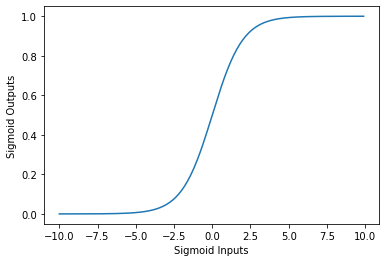

In [1]:
import numpy as np                  # 导入numpy科学运算库
import matplotlib.pyplot as plt     # 导入matplotlib绘图库

# 魔法指令，让matplotlib图形直接在jupyter notebook中显示
%matplotlib inline

def sigmoid(x):
    return 1.0/(1+np.exp(-x))             # 直接返回sigmoid函数
 
sigmoid_inputs = np.arange(-10,10,0.1)    # 参数: 起点，终点，间距
sigmoid_outputs = sigmoid(sigmoid_inputs)
 
plt.plot(sigmoid_inputs,sigmoid_outputs)
plt.xlabel("Sigmoid Inputs")
plt.ylabel("Sigmoid Outputs")
plt.show()

从上图可以看到 sigmoid 函数是一个 $S$ 形的曲线，它的取值在 `[0,1]` 之间，在远离 0 的地方函数的值会很快接近 0/1。这个性质使我们能够以概率的方式来解释。逻辑回归返回的是概率。一方面，你可以“原样”使用返回的概率（例如：用户点击此广告的概率为 0.00023），另一方面，也可以将返回的概率转换成二元值 `0` / `1`（例如，这封电子邮件是垃圾邮件）。对于垃圾邮件分类而言，因变量 (结果) 是二进制的，这意味着值可以用 `0` 或 `1` 表示。在这里，如果邮件是垃圾邮件，那么决策 (因变量或结果) 的值可以被认为是 `1`；否则，它就是 `0`。没有其他结果是可能的。自变量 (即特性) 将由电子邮件的各种属性组成，如某些关键字出现的次数等。然后我们可以使用逻辑回归算法创建一个模型来预测该邮件是否是垃圾邮件(`1`)或非垃圾邮件(`0`)。在这里，决策边界是通过训练一个逻辑回归模型来创建的，该模型可以帮助我们对垃圾邮件进行分类。

#### 决策函数

一个机器学习的模型，实际上是把决策函数限定在某一组条件下，这组限定条件就决定了模型的假设空间。当然，我们还希望这组限定条件简单而合理。而逻辑回归模型所做的假设是：

$$P(y=1|x;\theta) = g(\theta^T x) = \frac{1}{1 + e ^ {-\theta^T * x}}$$

这里的 $g(h)$ 是上边提到的 $sigmoid$ 函数，相应的决策函数为：

$$y^* = 1, \, \textrm{if} \, P(y=1|x) > 0.5$$

譬如：如果某个逻辑回归模型对某封电子邮件进行预测时返回的概率为 0.9995，则表示该模型预测这封邮件非常可能是垃圾邮件。相反，在同一个逻辑回归模型中预测分数为 0.0003 的另一封电子邮件很可能不是垃圾邮件。可如果某封电子邮件的预测分数为 0.6 呢？为了将逻辑回归值映射到二元类别，你必须指定 **分类阈值**（也称为判定阈值）。如果值高于该阈值，则表示 `垃圾邮件`；如果值低于该阈值，则表示 `非垃圾邮件`。人们往往会认为分类阈值应始终为 **0.5**。实际应用时，特定的情况可以选择不同阈值，如果对正例的判别准确性要求高，可以选择阈值大一些，对正例的召回要求高，则可以选择阈值小一些。

#### 参数求解

模型的数学形式确定后，剩下就是如何去求解模型中的参数。统计学中常用的一种方法是最大似然估计，即找到一组参数，使得在这组参数下，我们的数据的似然度（概率）越大。在逻辑回归模型中，似然度可表示为：

$$L(\theta) = P(D|\theta) = \prod P(y|x;\theta) = \prod g(\theta^T x) ^ y (1-g(\theta^T x))^{1-y}$$

取对数可以得到对数似然度：

$$l(\theta) = \sum {y\log{g(\theta^T x)} + (1-y)\log{(1-g(\theta^T x))}}$$

另一方面，在机器学习领域，我们更经常遇到的是损失函数的概念，其衡量的是模型预测错误的程度。常用的损失函数有 `0-1` 损失，$log$ 损失，$hinge$ 损失等。其中 $log$ 损失在单个数据点上的定义为：

$$-y\log{p(y|x)}-(1-y)\log{1-p(y|x)}$$

如果取整个数据集上的平均 $log$ 损失，我们可以得到

$$J(\theta) = -\frac{1}{N} l(\theta)$$

即在逻辑回归模型中，我们最大化似然函数和最小化 $log$ 损失函数实际上是等价的。对于该优化问题，存在多种求解方法，这里以梯度下降的为例说明。**梯度下降** (Gradient Descent) 又叫作：最速梯度下降，是一种迭代求解的方法。通过在每一步选取使目标函数变化最快的一个方向调整参数的值来逼近最优值。

基本步骤如下：
- 选择下降方向（梯度方向，$\nabla {J(\theta)}$）
- 选择步长，更新参数：$\theta^i = \theta^{i-1} - \alpha^i \nabla {J(\theta^{i-1})}$
- 重复以上两步直到满足终止条件

其中损失函数的梯度计算方法为：

$$\frac{\partial{J}}{\partial{\theta}} = -\frac{1}{n}\sum_i (y_i - y_i^*)x_i + \lambda \theta$$

沿梯度负方向选择一个较小的步长可以保证损失函数是减小的，另一方面，逻辑回归的损失函数是凸函数（加入正则项后是严格凸函数），可以保证我们找到的局部最优值同时是全局最优。此外，常用的凸优化的方法都可以用于求解该问题。例如：共轭梯度下降，牛顿法，LBFGS 等。

### 实验目标

在本实验中，我们将使用 logistic 回归分类算法，对 Amazon 上的乐器商品评论进行分类。

<img src="./img/musical instruments.jpg" width="80%">

### 1. 导入库

In [2]:
# 设置 nltk_data 路径环境变量
from nltk import data
data.path.append(r'../nltk_data')

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
from nltk import word_tokenize  #分词
from nltk.stem import WordNetLemmatizer  #词干提取
from sklearn.feature_extraction.text import TfidfVectorizer  #计算tf-idf
from collections import Counter  #词频统计
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')

### 2. 加载数据

实验数据集存储在 `./data/reviews_Musical_Instruments_5.json`，注意你应该以实际存储路径为准：

In [3]:
review_data = pd.read_json('./data/reviews_Musical_Instruments_5.json', lines=True)
review_data[['reviewText', 'overall']].head()

,reviewText,overall
0,"Not much to write about here, but it does exac...",5
1,The product does exactly as it should and is q...,5
2,The primary job of this device is to block the...,5
3,Nice windscreen protects my MXL mic and preven...,5
4,This pop filter is great. It looks and perform...,5


### 3. 数据清洗

数据清洗主要分为两步：
1. 使用正则表达式对文本进行分割并过滤一些特殊符号
2. 对分词进行小写变换并进行词干提取 (词形还原)

使用 `lambda` 函数从 DataFrame 的每个 `reviewText` 中提取标记，执行词形还原，并将它们并排连接起来。使用 `join` 函数将单词列表连接成一个句子。使用正则表达式方法 `re` 将除字母字符、数字和空格外的任何字符替换为空白。

In [4]:
lemmatizer = WordNetLemmatizer()
review_data['cleaned_review_text'] = review_data['reviewText'].apply(\
lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x)))]))

### 4. 查看数据

In [5]:
review_data[['cleaned_review_text', 'reviewText', 'overall']].head()

,cleaned_review_text,reviewText,overall
0,not much to write about here but it doe exactl...,"Not much to write about here, but it does exac...",5
1,the product doe exactly a it should and is qui...,The product does exactly as it should and is q...,5
2,the primary job of this device is to block the...,The primary job of this device is to block the...,5
3,nice windscreen protects my mxl mic and preven...,Nice windscreen protects my MXL mic and preven...,5
4,this pop filter is great it look and performs ...,This pop filter is great. It looks and perform...,5


### 5. 计算 TF-IDF 向量

计算清洗数据的 TF-IDF 并提取前 500 个关键词汇：

In [6]:
tfidf_model = TfidfVectorizer(max_features=500)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(review_data['cleaned_review_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,10,100,12,20,34,able,about,accurate,acoustic,actually,...,won,work,worked,worth,would,wrong,year,yet,you,your
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.159684,0.0,0.0,0.0,...,0.0,0.134327,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.085436,0.0,0.0,0.000000,0.0,0.0,0.0,0.067074,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.115312,0.0,0.0,0.0,0.079880,0.111989
3,0.0,0.0,0.0,0.0,0.0,0.339573,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.303608,0.000000


### 6. 对标签进行编码

由于原始文本是一个多分类样本，所以我们对其进行编码，创建一个新列 `target`，当总体参数 `overall`，即 `x<=4` 时编码为 `0`，否则编码为 `1`。

这样，将多分类问题转换为了二分类问题，可以使用逻辑回归进行分类：

In [7]:
review_data['target'] = review_data['overall'].apply(lambda x : 0 if x<=4 else 1)
review_data['target'].value_counts()

1    6938
0    3323
Name: target, dtype: int64

### 7. 创建逻辑回归模型

使用 tf-idf 向量和编码标签进行逻辑回归模型建立并进行预测得到概率。我们使用 scikit-learn 的 `LogisticRegression` 类创建基本模型。然后，利用 `fit()` 拟合函数对模型进行训练。然后，可以使用训练好的模型进行预测，另外，我们还可以使用 `predict_proba` 函数得到每个类的概率估计，示例代码如下：

```python
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X,y)
predicted_labels = log_reg.predict(X)
predicted_probability = log_reg.predict_proba(X)[:,1]
```

这里，`X` 代表一个特征变量的 DataFrame，而 `y` 代表一个目标变量 (标签) 的 DataFrame。将示例代码套用到我们的实验中：

In [8]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(tfidf_df, review_data['target']) # 指定标签列为新创建的 `target` 列
predicted_labels = logreg.predict(tfidf_df)
logreg.predict_proba(tfidf_df)[:,1]

array([0.57146961, 0.68579907, 0.56068939, ..., 0.65979968, 0.5495679 ,
       0.21186011])

关于逻辑回归的详细参数说明，[请查阅官方文档](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

### 8. 创建交叉表格

使用 pandas 的 `crosstab` 函数将分类模型的结果 (`predicted_labels`) 与商品评论的实际类 (`target`) 进行比较。此时的交叉表格相当于混淆矩阵：

In [9]:
review_data['predicted_labels'] = predicted_labels
pd.crosstab(review_data['target'], review_data['predicted_labels'])

predicted_labels,0,1
target,,
0,1543,1780
1,626,6312


在这里，我们可以看到：

- `1543` 个具有目标标签 `0` 的样本被正确分类，而 `1780` 个样本被错误分类。
- `6312` 个具有目标标签 `1` 的样本被正确分类，而 `626` 个样本被错误分类。

### 实验小结

在本实验中，你实现了使用逻辑回归进行文本分类。